### **Flower Classification**

In [1]:
# Loading Libraires
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset,DataLoader

In [2]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [12]:
                         
simple_transform = transforms.Compose([transforms.Resize((120,120))
                                       ,transforms.ToTensor(),
                                       transforms.Grayscale(num_output_channels=1)
                                      ])
dataset = ImageFolder('/content/drive/MyDrive/flower_photos',simple_transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 3670
    Root location: /content/drive/MyDrive/flower_photos
    StandardTransform
Transform: Compose(
               Resize(size=(120, 120), interpolation=bilinear)
               ToTensor()
               Grayscale(num_output_channels=1)
           )


In [13]:
#Loader
data_loader = DataLoader(dataset,batch_size=16,num_workers=3,shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
#Function to get Mean and std of dataset
def get_mean_std(loader):
    #VAR[X] = E[X**2] - E[X] **2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in loader:
        channels_sum +=torch.mean(data, dim=[0,2,3]) #BxCxHxW 
        channels_squared_sum+=torch.mean(data**2, dim=[0,2,3])
        num_batches +=1
        
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches -mean**2)**0.5
    
    return mean, std

In [15]:
mean, std = get_mean_std(data_loader)
print(mean)
print(std)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([0.4238])
tensor([0.2527])


In [16]:
#Spliting the dataset into training and testing
train, val = torch.utils.data.random_split(dataset, [2600,1070])

In [17]:
#DataLoader
train_data_loader = DataLoader(train,batch_size=16,num_workers=3,shuffle=True)
test_data_loader = DataLoader(val,batch_size=16,num_workers=3,shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
train[75][0]

tensor([[[0.3902, 0.3907, 0.3925,  ..., 0.4074, 0.4085, 0.4051],
         [0.3937, 0.3941, 0.3937,  ..., 0.4113, 0.4108, 0.4074],
         [0.3976, 0.3976, 0.3965,  ..., 0.4113, 0.4113, 0.4113],
         ...,
         [0.1786, 0.1650, 0.1192,  ..., 0.2330, 0.2077, 0.2960],
         [0.2317, 0.1816, 0.1830,  ..., 0.1713, 0.1494, 0.2146],
         [0.1277, 0.1407, 0.1592,  ..., 0.1493, 0.1089, 0.1574]]])

### **Custom CNN**

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
    
            
        self.fc1 = nn.Linear(7*7*256, 128)
        self.fc2 = nn.Linear(128, 5)   
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = F.dropout(out, training=self.training)
        out = self.fc2(out)
        return F.log_softmax(out,dim=1)

In [44]:
model = Net()
if is_cuda:
    model.cuda()

In [45]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [47]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   4.1 and training accuracy is 699/2600     26.88
validation loss is   1.9 and validation accuracy is 389/1070     36.36
training loss is   1.7 and training accuracy is 939/2600     36.12
validation loss is   1.5 and validation accuracy is 421/1070     39.35
training loss is   1.4 and training accuracy is 1079/2600      41.5
validation loss is   1.4 and validation accuracy is 471/1070     44.02
training loss is   1.3 and training accuracy is 1183/2600      45.5
validation loss is   1.3 and validation accuracy is 490/1070     45.79
training loss is   1.2 and training accuracy is 1336/2600     51.38
validation loss is   1.3 and validation accuracy is 496/1070     46.36
training loss is   1.1 and training accuracy is 1461/2600     56.19
validation loss is   2.0 and validation accuracy is 369/1070     34.49
training loss is   1.0 and training accuracy is 1569/2600     60.35
validation loss is   1.3 and validation accuracy is 539/1070     50.37
training loss is  0.92 and tr

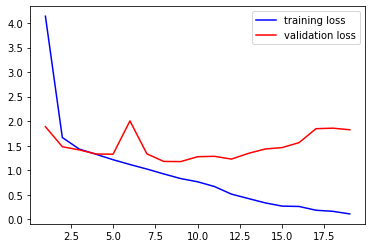

In [48]:
#Loss 
plt.plot(range(1,len(train_losses)+1),train_losses,'b',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

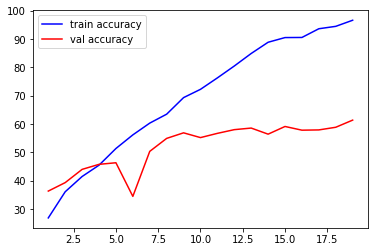

In [49]:
#Accuracy
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'b',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

### **Changing the Learning Rate**

In [50]:
model = Net()
if is_cuda:
    model.cuda()

In [51]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [52]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 1.3e+01 and training accuracy is 725/2600     27.88
validation loss is   1.5 and validation accuracy is 373/1070     34.86
training loss is   1.5 and training accuracy is 951/2600     36.58
validation loss is   1.7 and validation accuracy is 337/1070      31.5
training loss is   1.4 and training accuracy is 1044/2600     40.15
validation loss is   1.5 and validation accuracy is 358/1070     33.46
training loss is   1.4 and training accuracy is 1115/2600     42.88
validation loss is   1.6 and validation accuracy is 362/1070     33.83
training loss is   1.3 and training accuracy is 1190/2600     45.77
validation loss is   1.4 and validation accuracy is 435/1070     40.65
training loss is   1.3 and training accuracy is 1271/2600     48.88
validation loss is   1.4 and validation accuracy is 462/1070     43.18
training loss is   1.2 and training accuracy is 1317/2600     50.65
validation loss is   2.3 and validation accuracy is 298/1070     27.85
training loss is   1.2 and 

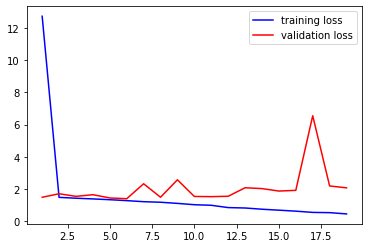

In [53]:
#Loss 
plt.plot(range(1,len(train_losses)+1),train_losses,'b',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

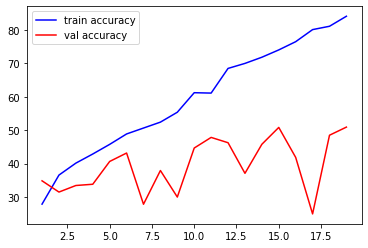

In [54]:
#Accuracy
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'b',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()